# Mean Reversion Strategy

Source: https://raposa.trade/blog/how-to-build-your-first-mean-reversion-trading-strategy-in-python/

Source: https://raposa.trade/blog/how-to-backtest-your-first-trading-strategy-in-python/

**Note**: This strategy works for some stocks, so the first step is to find stocks that have mean reversion trend.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

### The basic: Mean Reversion Strategy without safety threshold

To run this strategy, we’ll look at the SMA and see if the price is too high or low compared to the SMA. If the price is too low, we’ll buy it with the expectation that the price will go higher, towards the moving average. If it’s over extended to the upside, then we sell or go short, again with the expectation that the price is going to drop in the near term.

In [2]:
def SMAMeanReversion(ticker, sma, threshold, shorts=False,
    start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(data['extension']<-threshold,1, data['position'])
    if shorts:
        data['position'] = np.where(data['extension']>threshold, -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01, 0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns']  =  np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax() #Return cumulative maximum over a DataFrame or Series axis.
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [3]:
def SMABacktest(ticker, short_term_sma, long_term_sma, #calculate short and long term SMA
    shorts=False, start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    
    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, 0)
    
    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data

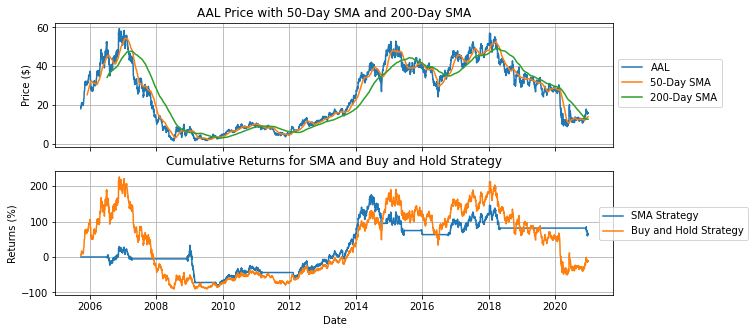

In [4]:
ticker = 'AAL'
short_term_sma = 50
long_term_sma = 200
data = SMABacktest(ticker, short_term_sma, long_term_sma)
fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)
ax[0].plot(data['Close'], label=ticker)
ax[0].plot(data['SMA1'], label=f"{short_term_sma}-Day SMA")
ax[0].plot(data['SMA2'], label=f"{long_term_sma}-Day SMA")
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price with {short_term_sma}-Day SMA and {long_term_sma}-Day SMA')
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].grid()
ax[1].plot((data['strat_cum_returns'] - 1) * 100, label='SMA Strategy')
ax[1].plot((data['cum_returns'] - 1) * 100, label='Buy and Hold Strategy')
ax[1].set_ylabel('Returns (%)')
ax[1].set_xlabel('Date')
ax[1].set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax[1].legend(bbox_to_anchor=[1.25, 0.75])
ax[1].grid()
plt.show()

In [5]:
def getStratStats(data, risk_free_rate=0.02):
# Work for long time frame and when peak (max cumulative return - cumulative return = 0)
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) \
        / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (
        buy_hold_strat['annual_returns'] - risk_free_rate) \
        / buy_hold_strat['annual_volatility']
    
    # Max Drawdown # don't really understnad the drawdown + it doesn't work with short time period
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]  #when peak (cummax of cum_return) - cum_return = 0
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    
    return stats_dict

In [6]:
def get_risk_return_Stats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate)/ sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate)/ buy_hold_strat['annual_volatility']
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    stats_df = pd.DataFrame(stats_dict).round(3)
    
    return stats_df

In [7]:
ticker = 'AAL'
SMA = 50
threshold = 0.1
shorts = False
start_date = '2020-01-01'
end_date = '2023-03-17'
data_test = SMAMeanReversion(ticker, SMA, threshold, shorts, start_date, end_date)

In [8]:
get_risk_return_Stats(data_test)

,strat_stats,base_stats
tot_returns,1.660,-0.132
annual_returns,0.384,-0.046
annual_volatility,0.521,0.702
sharpe_ratio,0.698,-0.094


### The advance: Mean Reversion with Safety Threshold

The **Simple Mean Reversion** strategy is susceptible to losses during large, downward moves. This can be seen clearly in the plot above where the model takes a large hit during the 2008 crisis and the more recent 2020 COVID crash. The model winds up being on the exact wrong position in these times because it decides to go long in the face of increased selling.

To address this, we can include a safety threshold, a point at which the model has become too extended so that momentum dominates over mean reversion and we should exit the position.

In [32]:
def SMAMeanReversionSafety(ticker, sma, threshold, 
    safety_threshold=0.25, shorts=False, 
    start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [33]:
ticker = 'AAL'
SMA = 50 # 50 is sweet spot for AAL
threshold = 0.1
safety_threshold = 0.15
shorts = False
start_date = '2020-01-01'
end_date = '2023-03-17'
data = SMAMeanReversion(ticker, SMA, threshold, shorts, start_date, end_date)
data_safe = SMAMeanReversionSafety(ticker, SMA, threshold, safety_threshold, shorts, start_date, end_date)

In [34]:
df_safe_stats = get_risk_return_Stats(data_safe)
df_stats = get_risk_return_Stats(data)
df_safe_stats.columns = ['Mean Reversion with Safety', 'Buy and Hold']
df_stats.columns = ['Mean Reversion', 'x']
df_stats = pd.concat([df_stats.T, df_safe_stats.T])
df_stats.drop('x', axis=0, inplace=True)
df_stats

,tot_returns,annual_returns,annual_volatility,sharpe_ratio
Mean Reversion,1.660,0.384,0.521,0.698
Mean Reversion with Safety,1.833,0.413,0.391,1.006
Buy and Hold,-0.132,-0.046,0.702,-0.094


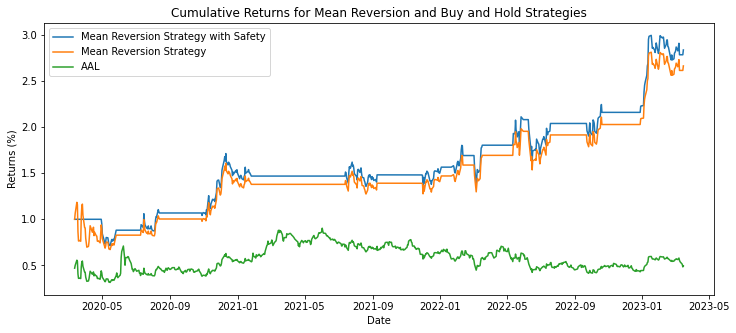

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_safe['strat_cum_returns'], label='Mean Reversion Strategy with Safety')
ax.plot(data['strat_cum_returns'], label='Mean Reversion Strategy')
ax.plot(data_safe['cum_returns'], label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')
ax.legend()
plt.show()

In [36]:
def SMA_plot(data,SMA):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
    long = data.loc[data['position']==1]['Close']
    ax[0].plot(data['Close'], label='Price', linestyle=':', color=colors[1])
    ax[0].plot(data['SMA'], label='SMA', linestyle='--', color=colors[0])
    ax[0].scatter(long.index, long, label='Long', c=colors[2])
    ax[0].legend(bbox_to_anchor=[1, 0.75])
    ax[0].set_ylabel('Price ($)')
    ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
    ax[1].plot(data['extension']*100, label='Extension', color=colors[0])
    ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
    ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
    ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
    ax[1].set_title('Price Extension and Buy/Sell Thresholds')
    ax[1].set_ylabel(f'Extension (%)')
    ax[1].legend(bbox_to_anchor=[1, 0.75])
    ax[2].plot(data['position'])
    ax[2].set_xlabel('Date')
    ax[2].set_title('Position')
    ax[2].set_yticks([-1, 0, 1])
    ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
    plt.tight_layout()
    return plt.show()

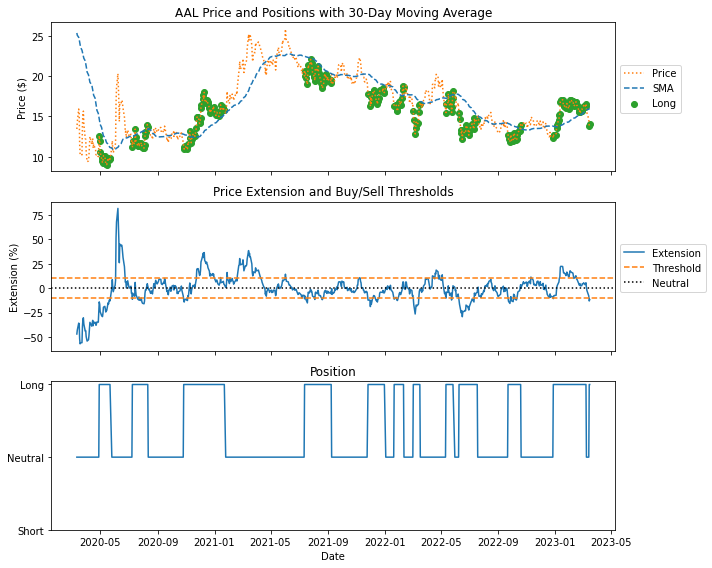

In [37]:
SMA_plot(data_safe, SMA = 30)

### Test different moving average to find the sweet spot

In [38]:
# get stock data of 1 stock
def get_stock_data_yahoo(ticker,start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    return data

In [39]:
def SMAMeanReversionSafety(data, sma, threshold, safety_threshold=0.25, shorts=False):
    
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [40]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-03-20'
apple = get_stock_data_yahoo(ticker, start_date, end_date)

In [41]:
sma_list = []
for sma in (30,50,70,100,120):
    data =  SMAMeanReversionSafety(apple, sma, threshold = 0.1 ,safety_threshold = 0.2)
    df_stats = get_risk_return_Stats(data)
    strat_stats = df_stats['strat_stats']
    sma_case = {'sma': sma,
               'tot_returns': strat_stats['tot_returns'],
               'annual_returns':strat_stats['annual_returns'],
               'annual_volatility': strat_stats['annual_volatility'],
               'sharpe_ratio': strat_stats['sharpe_ratio']}
    sma_list.append(sma_case)
    
sma_df = pd.DataFrame(sma_list)
sma_df.set_index('sma')

,tot_returns,annual_returns,annual_volatility,sharpe_ratio
sma,,,,
30,0.272,0.081,0.207,0.295
50,0.552,0.157,0.195,0.704
70,0.576,0.167,0.138,1.066
100,0.219,0.073,0.123,0.429
120,0.150,0.053,0.113,0.288


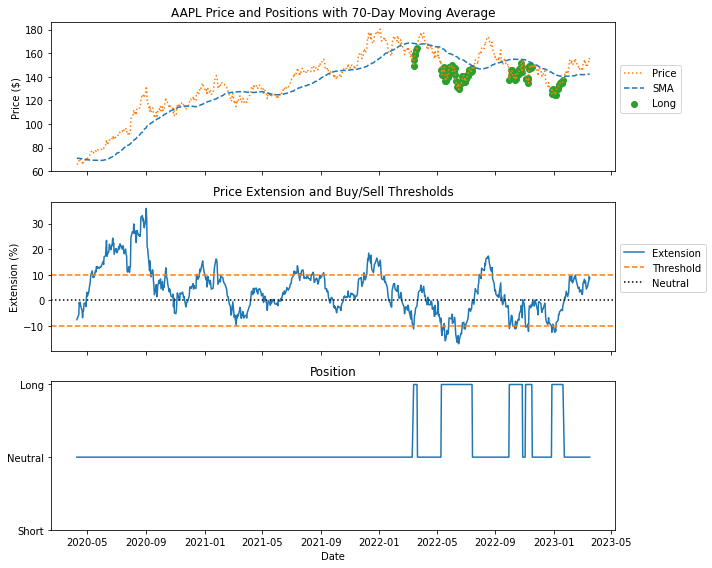

In [42]:
apple_70 = SMAMeanReversionSafety(apple, 70, threshold = 0.1 ,safety_threshold = 0.2)
SMA_plot(apple_70, SMA = 70)

In [20]:
#KO - Coca Cola
ticker = 'KO'
start_date = '2020-01-01'
end_date = '2023-03-20'
ko_data = get_stock_data_yahoo(ticker, start_date, end_date)

In [21]:
sma_list = []
for sma in (10,30,50,70,100):
    data =  SMAMeanReversionSafety(ko_data, sma, threshold = 0.1 ,safety_threshold = 0.2)
    df_stats = get_risk_return_Stats(data)
    strat_stats = df_stats['strat_stats']
    sma_case = {'sma': sma,
               'tot_returns': strat_stats['tot_returns'],
               'annual_returns':strat_stats['annual_returns'],
               'annual_volatility': strat_stats['annual_volatility'],
               'sharpe_ratio': strat_stats['sharpe_ratio']}
    sma_list.append(sma_case)
    
sma_df = pd.DataFrame(sma_list)
sma_df.set_index('sma')

,tot_returns,annual_returns,annual_volatility,sharpe_ratio
sma,,,,
10,-0.099,-0.032,0.111,-0.473
30,-0.070,-0.023,0.137,-0.316
50,0.035,0.011,0.144,-0.059
70,0.106,0.035,0.074,0.199
100,0.222,0.074,0.044,1.212


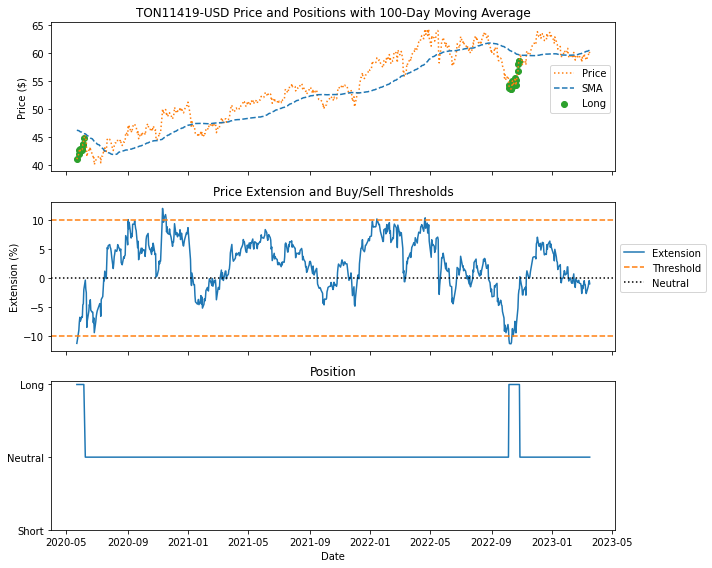

In [28]:
ko_100 = SMAMeanReversionSafety(ko_data, 100, threshold = 0.1 ,safety_threshold = 0.2)
SMA_plot(ko_100,SMA = 100)

In [46]:
import plotly.graph_objects as go

candlestick = go.Candlestick(
    x=ko_data.index,
    open=ko_data['Open'],
    high=ko_data['High'],
    low=ko_data['Low'],
    close=ko_data['Close'])

# Create a candlestick figure   
fig = go.Figure(data=[candlestick])
fig.update_layout(title='CocaCola prices')                        
# Show the plot
fig.show()

## Crypto

In [24]:
def get_risk_return_Stats_crypto(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 365) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 365) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(365)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(365)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate)/ sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate)/ buy_hold_strat['annual_volatility']
    
    stats_dict = {'strat_stats': sma_strat,
                  'base_stats': buy_hold_strat}
    stats_df = pd.DataFrame(stats_dict).round(3)
    
    return stats_df

In [25]:
ticker = 'TON11419-USD'
start_date = '2021-08-23'
end_date = '2023-03-21'
crypto_data = get_stock_data_yahoo(ticker, start_date, end_date)

In [26]:
sma_list = []
for sma in (10,30,50,70,100,120):
    data =  SMAMeanReversionSafety(crypto_data, sma, threshold = 0.1 ,safety_threshold = 0.2)
    df_stats = get_risk_return_Stats_crypto(data)
    strat_stats = df_stats['strat_stats']
    sma_case = {'sma': sma,
               'tot_returns': strat_stats['tot_returns'],
               'annual_returns':strat_stats['annual_returns'],
               'annual_volatility': strat_stats['annual_volatility'],
               'sharpe_ratio': strat_stats['sharpe_ratio']}
    sma_list.append(sma_case)
    
sma_df = pd.DataFrame(sma_list)
sma_df.set_index('sma')

,tot_returns,annual_returns,annual_volatility,sharpe_ratio
sma,,,,
10,-0.420,-0.298,0.679,-0.469
30,0.196,0.128,0.900,0.120
50,2.102,1.207,1.154,1.029
70,0.395,0.274,0.824,0.308
100,-0.450,-0.370,0.611,-0.638
120,-0.360,-0.303,0.704,-0.459


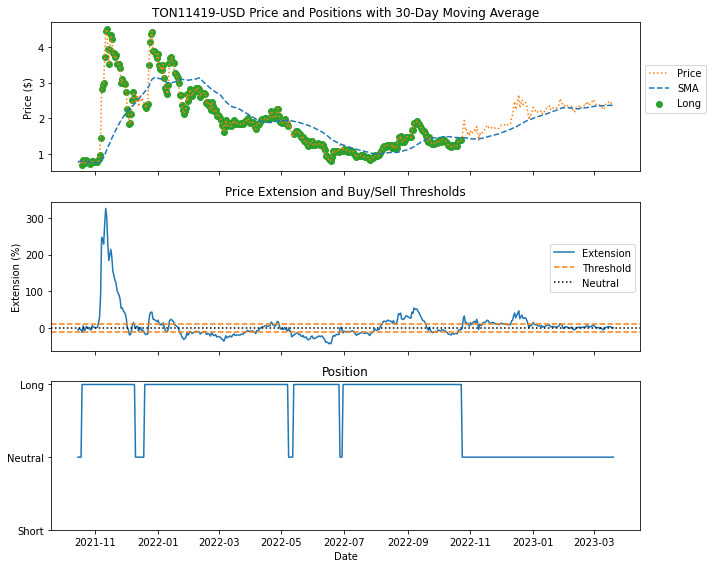

In [27]:
ton_data_50 = SMAMeanReversionSafety(crypto_data, 50, threshold = 0.1,safety_threshold = 0.2)
SMA_plot(ton_data_50)